In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import numpy as np

In [3]:
import sys
sys.path.append('../..')

In [4]:
from magrec import __datapath__

from magrec.prop.Pipeline import (
    Pipe,
    Union,
    PlotResults,
    Projection,
    CurrentLayerToField,
    FourierZeroDivergenceConstraint2d,
    GaussianFilter,
    Function,
    Padder
)

import torchvision.transforms as T

/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <59ED1CF5-3CD8-3592-A70B-3AB98E4C5F21> /opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [28]:
# experimental data where three components of the magnetic field are measured above an Nb wire
# data is from DOI: 10.1103/PhysRevApplied.14.024076
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = torch.tensor(np.array([Bx, By, Bz]), dtype=torch.float32)

In [6]:
dx = 0.408  # in μm
dy = 0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

# this is an axis along which the magnetic field is *usually* measured
# in this case we will project the measured components to simulate such case
theta = 54.7            # degrees
phi = 45.0              # degrees

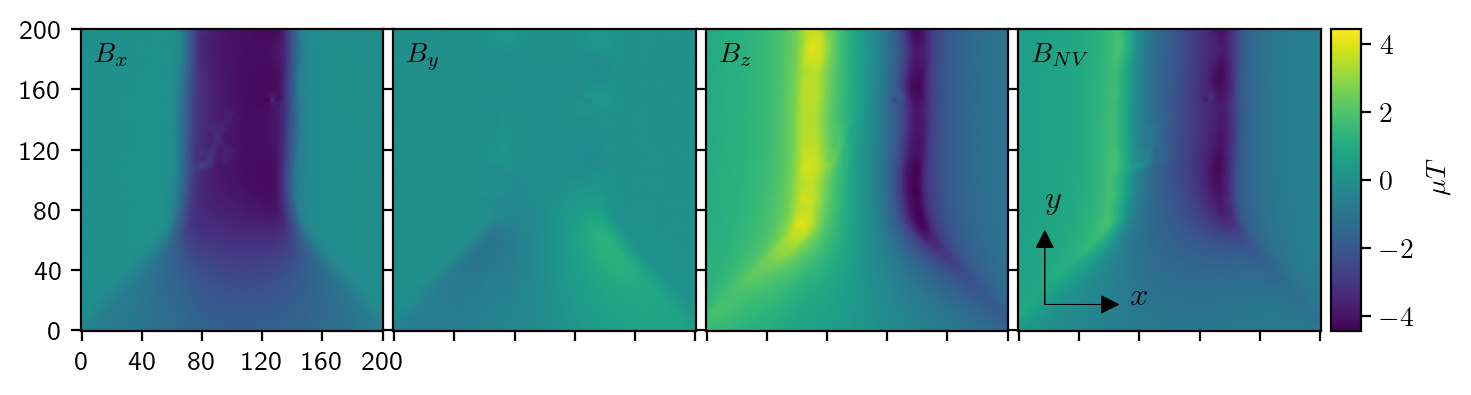

In [7]:
pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
])

pipe.fit(B).transform(B);

The goal is to be able to fit this magnetic field to a current distribution. We know here that this magnetic field is produced by a 2d current distribution confined in a layer of thickness `layer_thickness` at the distance `height` below where the magnetic field was measured. But we are not there yet. 

Instead, I can produce a magnetic field from a given current distribution. The idea is to calculate loss by comparing the magnetic field and update the current distribution to minimize the loss.

Below I show how given a current distribution one obtains the magnetic field in this `Pipeline` approach. I will use ``

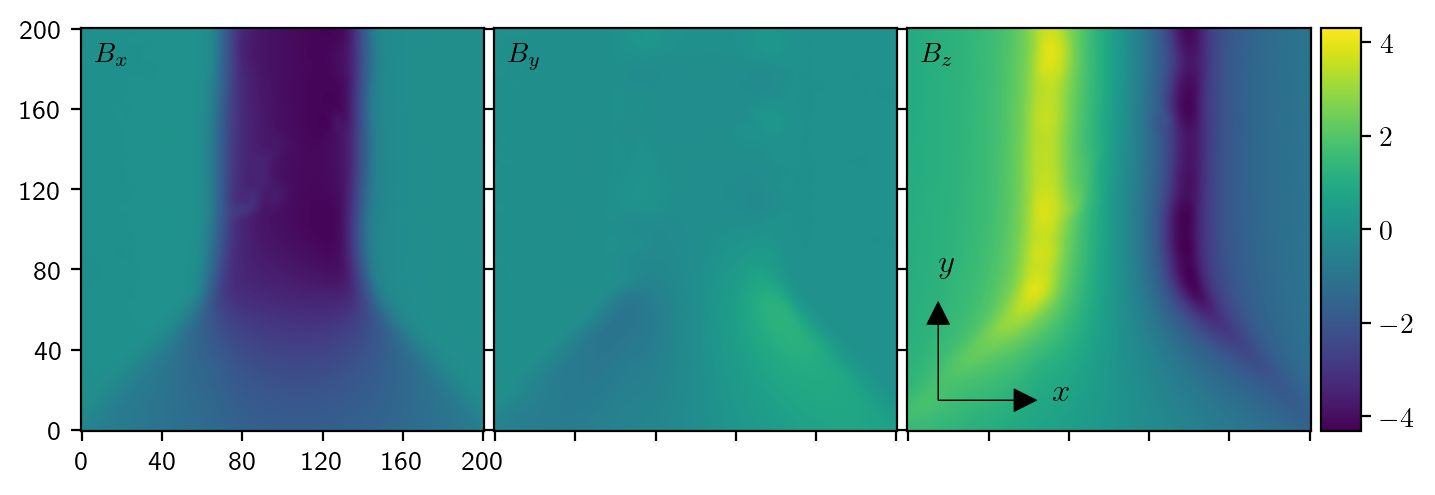

In [17]:
import pytorch_lightning as L


_, W, H = B.shape

padder = Padder(up_to=(16 * 12, 16 * 8))

pipe = Pipe(
    [
        ("add_batch_dim", Function(lambda x: x[None, ...])),
        ("gaussian_filter", GaussianFilter(2.0)),
        ("plot1", PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"])),
        ("B_NV", Function(lambda x: x[..., 0:1, :, :])),
    ]
)

pipe.fit(B).transform(B)

model = Pipe(
    [
        ("JxJy", "passthrough"),
        ("plot1", PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
        (
            "B",
            CurrentLayerToField(
                dx=dx, dy=dy, height=height, layer_thickness=layer_thickness
            ),
        ),
        (
            "B+B_NV",
            Union(
                [("B", "passthrough"), ("B_NV", Projection(theta=theta, phi=phi))],
                dim=-3,
            ),
        ),
        (
            "plot2",
            PlotResults(
                labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$"
            ),
        ),
        ("B_NV", Function(lambda x: x[..., [-1], :, :])),
        ("ROI", Function(T.CenterCrop(size=(W, H)))),
    ]
)

class NeuralDivergenceLoss(L.LightningModule):
    def __init__(self, net, model):
        super().__init__()
        self.net = net 
        self.model = model
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.net(x)
        loss = self.loss_fn(z)
        return loss
            
    def loss_fn(self, net_output):
        J = net_output["J"]
        field_loss, div_loss = self.model.propagate(JxJy=J, get_loss=("B_NV", "div"))
        return field_loss + div_loss
    
    


# div_recon2 = PrototypeWithDivergence(
#     net=GioCNN(size_out=(128, 128), n_channels_in=1, n_channels_out=2),
#     model=model,
#     max_epochs=20,
#     optimizer=torch.optim.SGD,
# )

In [8]:
from current_reconstruction import test, get_last_checkpoint, MagneticFieldObservations2d
from magrec import __datapath__, __logpath__

In [9]:
model = test()

In [10]:
# Evaluate model at a set of points that cover the entire image
# and plot the results. The set of points is 200 x 200 = 40,000 points.

xs = torch.linspace(-1, 2, 200)
ys = torch.linspace(-1, 2, 200)
pts = torch.stack(torch.meshgrid(xs, ys, indexing='xy'), dim=-1).reshape(-1, 2)
vals = model(pts).detach().reshape(2, 200, 200).numpy()

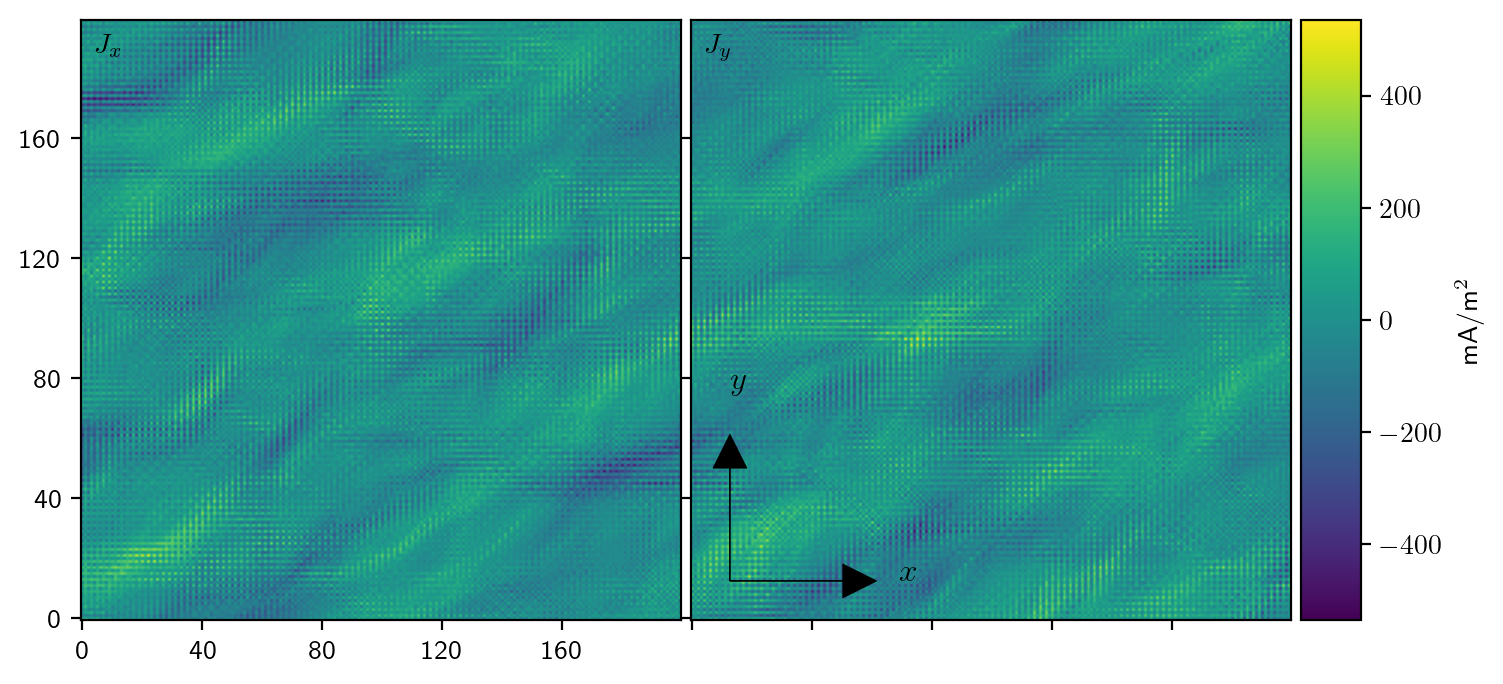

In [14]:
from magrec.misc.plot import plot_n_components


plot_n_components(vals, labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")

TypeError: FourierFeaturesPINN.validation_step() missing 2 required positional arguments: 'batch' and 'batch_idx'